<a href="https://colab.research.google.com/github/hachteja/Timed-Interventions/blob/main/TimedIntervention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding and Predicting the COVID-19 Pandemic 
## A modified timed-intervention SEIR model

*Model created by Gary D. Hachtel, May 11th 2020*

*Notebook created Jordan A. Hachtel, December 3rd 2020*



This is an iPython notebook that can be used to download and visualize the latest data for the US from the COVID Tracking Project, to define individual model parameters and compare the model to data, and to predict the future of the pandemic as a function of different schedules of timed interventions.


In [ ]:
#@title Import Standard Python Libraries
import matplotlib.pyplot as plt
import numpy as np
import requests
from scipy.integrate import odeint
%matplotlib inline

In [ ]:
#@title Define the Timed Intervention Model

def derivTI(y,t,N,Interventions,alpha0,phi0,beta,gamma,delta,lambdat,kappa,rho,nu):
    S,P,E,I,Q,R,D = y
    dIdt = - delta *I      +  gamma*E  - (rho + nu)*I
    dQdt =   delta*I -(lambdat + kappa)*Q
    dRdt =             lambdat*Q             +    nu*I
    dDdt =                       kappa*Q + rho*I
    if t<Interventions[0,0]: #### Before First Intervention
        dSdt =  -beta*S*I/N**power - alpha0*S + phi0*P
        dPdt =                       alpha0*S - phi0*P
        dEdt =   beta*S*I/N**power - (gamma)*E      
    else:
        for intervention in Interventions:
            if t >= intervention[0]: #### Between Remaining Interventions
                dSdt =  -beta*S*I/N**power - intervention[1]*S  + intervention[2]*P 
                dPdt =                       intervention[1]*S  - intervention[2]*P
                dEdt =   beta*S*I/N**power - (gamma)*E
    return dSdt, dPdt, dEdt, dIdt, dQdt, dRdt, dDdt

In [ ]:
#@title Download Latest Data from the COVID Tracking Project (https://covidtracking.com/)

#Download Data
fname='https://api.covidtracking.com/v1/us/daily.csv'
covid_data=requests.get(fname).text.split('\n')

#Read Total Cases, Recovered Cases, and Total Deaths into Separate Variables
CCases,RCases,CDeaths=[],[],[]
Data=[CCases,RCases,CDeaths]
Dates=[]
use_i=[2,11,13]
for line in covid_data[1:-1]:
    l=line.split(',')
    Dates.append(l[0])
    for i in range(3):
        try: Data[i].append(int(l[use_i[i]]));
        except ValueError: continue
TCases=np.asarray(CCases)[::-1]
RCases=np.asarray(RCases)[::-1]
TDeaths=np.asarray(CDeaths)[::-1]
Dates=np.asarray(Dates)[::-1]

### NOTE: Not all dates have defined values from start of pandemic. It is necessary to distinguish between the first date with defined values for all variables. 
### First recorded cases occur on January 22nd 2020, so all dates are measured from that with Off_R and Off_D being the date offset needed to reach the first 
### dates with recorded values for Recovered and Deceased Respectively

N_TC,N_RC,N_TD=TCases.shape[0],RCases.shape[0],TDeaths.shape[0]
t_Data=np.arange(1,N_TC+1)
Off_R=N_TC-N_RC
Off_D=N_TC-N_TD
disp_xlab='t (Days from '+Dates[0][4:6]+'-'+Dates[0][6:]+'-'+Dates[0][:4]+')'

#Defines Cases/Recovered/Deaths Per Day
TCasesPD=np.diff(TCases)
RCasesPD=np.diff(RCases)
TDeathsPD=np.diff(TDeaths)

#Define 7 Day Rolling Averages of Per Day Values
def rolling_average(arr, N):
    return np.asarray([np.average(arr[i:i+N]) for i in range(len(arr)-N)])

TCasesPD_av=np.asarray([np.average(TCasesPD[i:i+7]) for i in range(len(TCasesPD)-7)])
RCasesPD_av=np.asarray([np.average(RCasesPD[i:i+7]) for i in range(len(RCasesPD)-7)])
TDeathsPD_av=np.asarray([np.average(TDeathsPD[i:i+7]) for i in range(len(TDeathsPD)-7)])

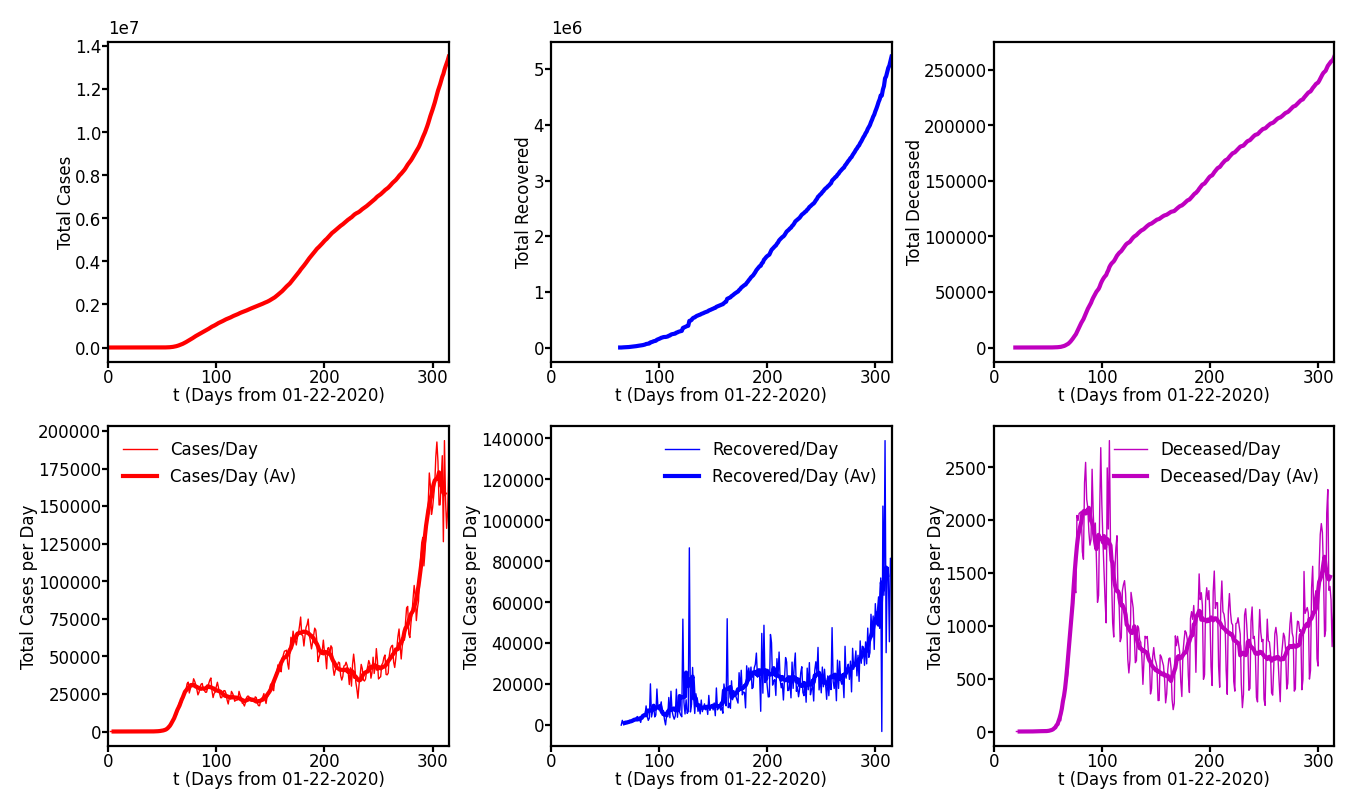

In [ ]:
#@title Display COVID-19 Data

f,a=plt.subplots(2,3,dpi=200,figsize=(6.7,4))
plt.subplots_adjust(bottom=0.11,top=0.99,right=0.995,left=0.08,wspace=0.3)
a[0,0].plot(t_Data,TCases,color='r',lw=1.5)
a[0,0].set_ylabel('Total Cases',fontsize=6,labelpad=0)
a[0,0].set_xlabel(disp_xlab,fontsize=6,labelpad=0)

a[1,0].plot(t_Data[1:],TCasesPD,color='r',lw=0.5,label='Cases/Day')
a[1,0].plot(t_Data[4:-4],TCasesPD_av,color ='r',lw=1.5,label='Cases/Day (Av)')
a[1,0].set_ylabel('Total Cases per Day',fontsize=6,labelpad=0)
a[1,0].set_xlabel(disp_xlab,fontsize=6,labelpad=0)
a[1,0].legend(frameon=False,fontsize=6)

a[0,1].plot(t_Data[Off_R:],RCases,color='b',lw=1.5)
a[0,1].set_ylabel('Total Recovered',fontsize=6,labelpad=0)
a[0,1].set_xlabel(disp_xlab,fontsize=6,labelpad=0)

a[1,1].plot(t_Data[Off_R+1:],RCasesPD,color='b',lw=0.5,label='Recovered/Day')
a[1,1].plot(t_Data[Off_R+4:-4],RCasesPD_av,color ='b',lw=1.5,label='Recovered/Day (Av)')
a[1,1].set_ylabel('Total Cases per Day',fontsize=6,labelpad=0)
a[1,1].set_xlabel(disp_xlab,fontsize=6,labelpad=0)
a[1,1].legend(frameon=False,fontsize=6)

a[0,2].plot(t_Data[Off_D:],TDeaths,color='m',lw=1.5)
a[0,2].set_ylabel('Total Deceased',fontsize=6,labelpad=0)
a[0,2].set_xlabel(disp_xlab,fontsize=6,labelpad=0)

a[1,2].plot(t_Data[Off_D+1:],TDeathsPD,color='m',lw=0.5,label='Deceased/Day')
a[1,2].plot(t_Data[Off_D+4:-4],TDeathsPD_av,color ='m',lw=1.5,label='Deceased/Day (Av)')
a[1,2].set_ylabel('Total Cases per Day',fontsize=6,labelpad=0)
a[1,2].set_xlabel(disp_xlab,fontsize=6,labelpad=0)
a[1,2].legend(frameon=False,fontsize=6)

for row in a: 
  for ax in row:
    ax.set_xlabel(disp_xlab,fontsize=6,labelpad=0)
    ax.tick_params(labelsize=6,length=2,pad=0.5)
    ax.set_xlim(0,t_Data[-1])
    ax.yaxis.get_offset_text().set_fontsize(6)

Initial Conditions
	Susceptible: 349997499
	Protected: 1
	Exposed: 2000
	Infected: 500
	Quarantined: 0
	Recovered: 0
	Deceased: 0

Model Parameters
	alpha_0: 0.0
	phi_0: 0.001
	beta: 0.92
	gamma: 0.0305
	delta: 0.02
	lambda: 0.07
	kappa: 0.00368421052631579
	nu: 0.1
	rho: 0.005
	power: 1

Timed Interventions
		Days of Interventions (tau): 64 150 178 250
		S-P Transfer Rates (alpha): 0.2 0.05 0.45 0.05
		P-S Transfer Rates (phi): 0.0065 0.05 0.035 0.025

Predicting from Day 0 out to 315 Days


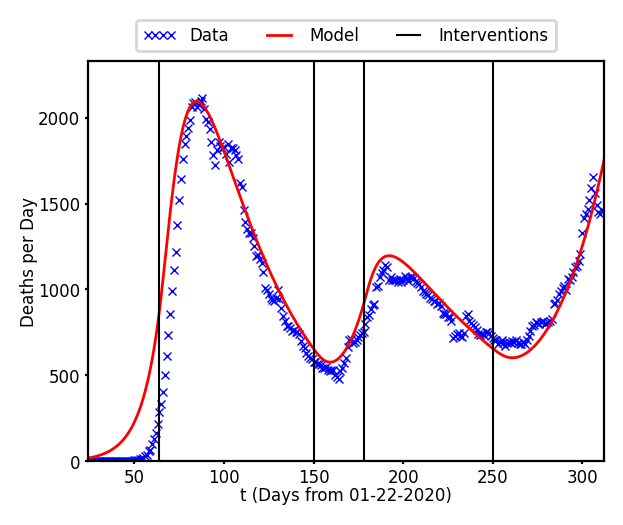

In [ ]:
#@title Define Parameters for Model, Solve the Model, and Compare to Data

#NOTE: To change model and see results modfiy the following parameters, and 
#run cell to compare to data.

#Starting Parameters
N=350000000
DI=0
RI=0###fromCovidtrackijng.com on Patriots day
II=500
EI=4*II
QI=0
PI=1
SI=N-(PI+EI+II+QI+RI+DI)

#Model Parameters
alpha0=0.0
phi0 = 0.001
beta = 0.92
gamma = 0.0305
delta = 0.02
lambdat = 0.07
nu = 0.1
kappa =  lambdat/19.
rho = nu/20.

#Intervention Parameters
tau=[64,150,178,250]
alpha=[0.2,0.05,0.45,0.05]
phi=[0.0065,0.05,0.035,0.025]

#Days to solve
start=0
n_solve=t_Data[-1]

################################################################################

print('Initial Conditions')
print('\tSusceptible:',SI)
print('\tProtected:',PI)
print('\tExposed:',EI)
print('\tInfected:',II)
print('\tQuarantined:',QI)
print('\tRecovered:',RI)
print('\tDeceased:',DI )
print()
print('Model Parameters')
print('\talpha_0:',alpha0)
print('\tphi_0:',phi0)
print('\tbeta:',beta)
print('\tgamma:',gamma)
print('\tdelta:',delta)
print('\tlambda:',lambdat)
print('\tkappa:',kappa)
print('\tnu:',nu)
print('\trho:',rho)
print('\tpower:',power)
print()

print('Timed Interventions')
print('\t\tDays of Interventions (tau):',*tau)
print('\t\tS-P Transfer Rates (alpha):',*alpha)
print('\t\tP-S Transfer Rates (phi):',*phi)
print()

print('Predicting from Day',start,'out to',n_solve,'Days')

#Define Global Parameters for Remainder of Analysis
y_init = SI, PI, EI, II, QI, RI, DI #Initial conditions vector
TIs=np.asarray([tau,alpha,phi]).T #Timed interventions vector

#Solve Model
t_TR = np.arange(start,start+n_solve).astype(float) #time vector in days
populations = odeint(derivTI, y_init, t_TR, args=(N,TIs,alpha0,phi0,beta,gamma,delta,lambdat,kappa,rho,nu))
S, P, E, I, Q, R, D = populations.T ; DPD=np.diff(D)

#Display Model
f=plt.figure(figsize=(3,2.5),dpi=200)
a=f.add_subplot(111)
plt.subplots_adjust(left=0.13,right=0.99,top=0.9,bottom=0.1,wspace=0.3)
a.plot(t_Data[Off_D+4:-4],TDeathsPD_av,marker='x',mec='b',ms=3,mew=0.5,lw=0,label='Data')
a.plot(t_TR[1:],DPD,color='r',lw=1,label='Model')
a.set_ylabel('Deaths per Day',fontsize=6,labelpad=0)
a.tick_params(labelsize=6,length=1,pad=1.75)
a.set_xlim(t_Data[Off_D+4],t_Data[-4])
a.set_xlabel(disp_xlab,fontsize=6,labelpad=0)
a.set_ylim(0,np.amax(TDeathsPD_av)*1.1)
for t in tau: a.axvline(t,color='k',lw=0.75,label='Interventions')
h,l=a.get_legend_handles_labels()
leg=a.legend(handles=h[:3],labels=l[:3],fontsize=6,numpoints=4,ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.125))


Final Intervention
		Day of Intervention (tau): 350
		S-P Transfer Rate (alpha): 0.2
		P-S Transfer Rate (phi): 0.005

Predicting from Day 0 out to 1460 Days


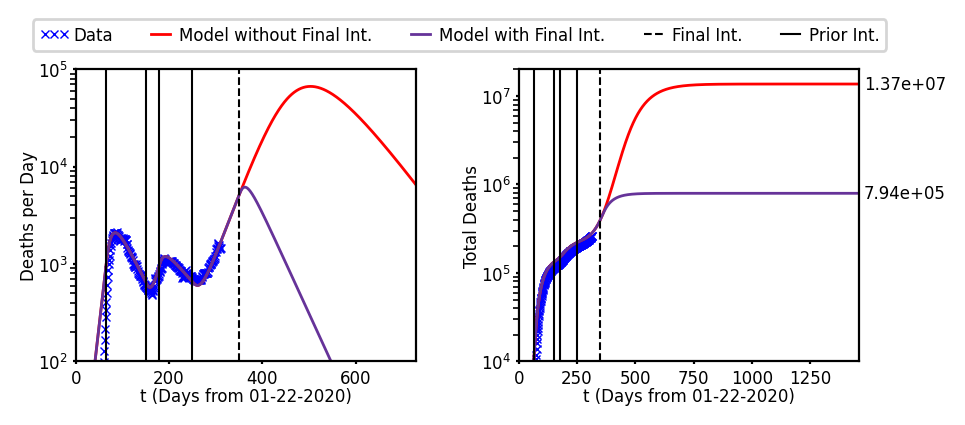

In [ ]:
#@title Introduce Final Intervention, and Compare to Predictions without Final Intervention

#Set Parameters for Final Intervention
tau_final=350
alpha_final=0.2
phi_final=0.005

#Days to solve
start=0
n_solve=4*365

#Calculate model with final intervention
t_TR = np.arange(start,start+n_solve).astype(float) #time vector in days
TIs_final=np.append(TIs,[tau_final,alpha_final,phi_final]).reshape((len(TIs)+1,3)) #TIs vector with final intervention
populations = odeint(derivTI, y_init, t_TR, args=(N,TIs,alpha0,phi0,beta,gamma,delta,lambdat,kappa,rho,nu)) #Populations without Final Intervention
populations_final = odeint(derivTI, y_init, t_TR, args=(N,TIs_final,alpha0,phi0,beta,gamma,delta,lambdat,kappa,rho,nu)) #Populations without Final Intervention

S, P, E, I, Q, R, D = populations.T ; DPD=np.diff(D)
S_f, P_f, E_f, I_f, Q_f, R_f, D_f = populations_final.T ; DPD_f=np.diff(D_f)

print('Final Intervention')
print('\t\tDay of Intervention (tau):',tau_final)
print('\t\tS-P Transfer Rate (alpha):',alpha_final)
print('\t\tP-S Transfer Rate (phi):',phi_final)
print()

print('Predicting from Day',start,'out to',n_solve,'Days')

#Display Predictions
f,a=plt.subplots(1,2,figsize=(4.75,2),dpi=200)
plt.subplots_adjust(left=0.075,right=0.9,top=0.85,bottom=0.12,wspace=0.3)
a[0].plot(t_Data[Off_D+4:-4],TDeathsPD_av,marker='x',mec='b',ms=3,mew=0.5,lw=0,label='Data')
a[0].plot(t_TR[1:],DPD,color='r',lw=1,label='Model without Final Int.')
a[0].plot(t_TR[1:],DPD_f,color='RebeccaPurple',lw=1,label='Model with Final Int.')
a[0].set_ylabel('Deaths per Day',fontsize=6,labelpad=0)
a[0].set_xlim(start,start+365*2)
a[0].set_ylim(1e2,1e5)

a[1].plot(t_Data[N_Max-N_TD:],TDeaths,marker='x',mec='b',ms=3,mew=0.5,lw=0,label='Data')
a[1].plot(t_TR,D,color='r',lw=1)
a[1].plot(t_TR,D_f,color='RebeccaPurple',lw=1)
a[1].set_xlim(start,start+n_solve)
a[1].set_ylabel('Total Deaths',fontsize=6,labelpad=0)
a[1].text(start+365*4.05,D[-1],"{:.2e}".format(D[-1]),ha='left',va='center',fontsize=6)
a[1].text(start+365*4.05,D_f[-1],"{:.2e}".format(D_f[-1]),ha='left',va='center',fontsize=6)
a[1].set_ylim(1e4,2e7)

for ax in a:
  ax.axvline(tau_final,color='k',ls='--',lw=0.75,label='Final Int.')
  for t in tau: ax.axvline(t,color='k',lw=0.75,label='Prior Int.')
  ax.set_xlabel(disp_xlab,fontsize=6,labelpad=0)
  ax.set_yscale('log')
  ax.tick_params(labelsize=6,length=1,pad=1.75)

h,l=a[0].get_legend_handles_labels()
leg=a[0].legend(handles=h[:5],labels=l[:5],fontsize=6,numpoints=3,handlelength=1.75,ncol=5,
           loc='upper left',bbox_to_anchor=(-0.15,1.2),columnspacing=2.0,handletextpad=0.25,)

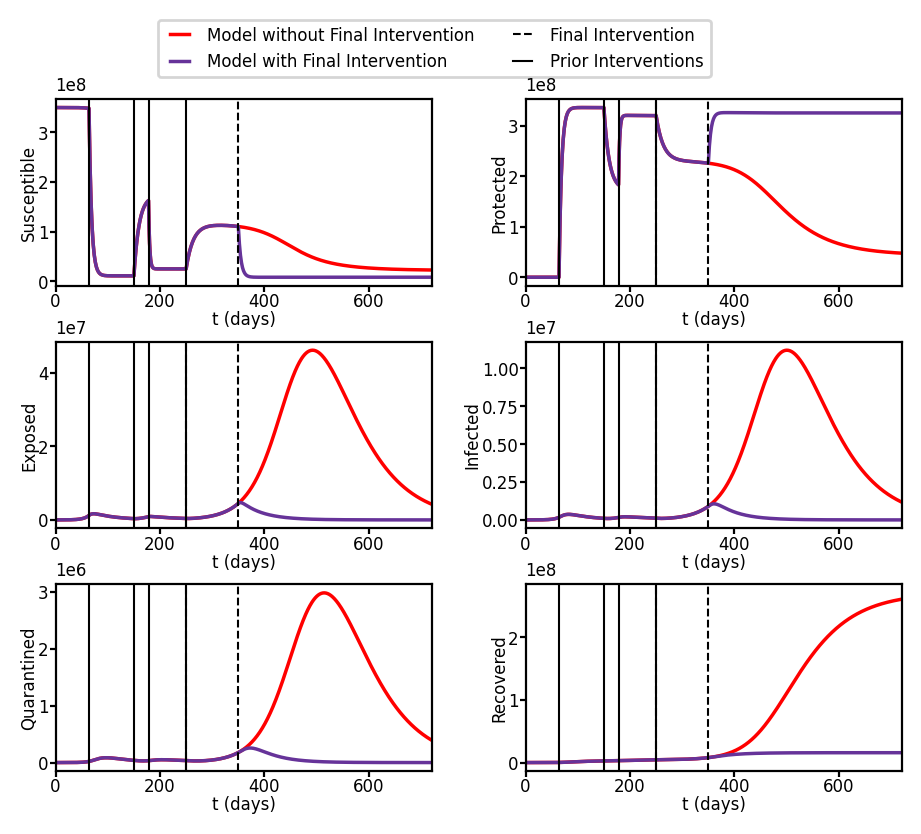

In [ ]:
#@title Display All State Values for 4 Year Prediction

f,a=plt.subplots(3,2,dpi=200,figsize=(4.5,4))
plt.subplots_adjust(left=0.05,right=0.99,top=0.89,bottom=0.05,wspace=0.25,hspace=0.3)
a[0,0].plot(t_TR,S,color='r',lw=1.25,label='Model without Final Intervention')
a[0,0].plot(t_TR,S_f,color='RebeccaPurple',lw=1.25,label='Model with Final Intervention')
a[0,0].set_ylabel('Susceptible',labelpad=0,fontsize=6)

a[0,1].plot(t_TR,P,color='r',lw=1.25)
a[0,1].plot(t_TR,P_f,color='RebeccaPurple',lw=1.25)
a[0,1].axvline(tau[-1],color='k',ls='--',lw=0.75)
a[0,1].set_ylabel('Protected',labelpad=0,fontsize=6)

a[1,0].plot(t_TR,E,color='r',lw=1.25)
a[1,0].plot(t_TR,E_f,color='RebeccaPurple',lw=1.25)
a[1,0].axvline(tau[-1],color='k',ls='--',lw=0.75)
a[1,0].set_ylabel('Exposed',labelpad=0,fontsize=6)

a[1,1].plot(t_TR,I,color='r',lw=1.25)
a[1,1].plot(t_TR,I_f,color='RebeccaPurple',lw=1.25)
a[1,1].axvline(tau[-1],color='k',ls='--',lw=0.75)
a[1,1].set_ylabel('Infected',labelpad=0,fontsize=6)

a[2,0].plot(t_TR,Q,color='r',lw=1.25)
a[2,0].plot(t_TR,Q_f,color='RebeccaPurple',lw=1.25)
a[2,0].axvline(tau[-1],color='k',ls='--',lw=0.75)
a[2,0].set_ylabel('Quarantined',labelpad=0,fontsize=6)

a[2,1].plot(t_TR,R,color='r',lw=1.25)
a[2,1].plot(t_TR,R_f,color='RebeccaPurple',lw=1.25)
a[2,1].axvline(tau[-1],color='k',ls='--',lw=0.75)
a[2,1].set_ylabel('Recovered',labelpad=0,fontsize=6)

for row in a:
    for axis in row:
        axis.axvline(tau_final,color='k',ls='--',lw=0.75,label='Final Intervention')
        for t in tau: axis.axvline(t,color='k',lw=0.75,label='Prior Interventions')
        axis.set_xlabel('t (days)',labelpad=0,fontsize=6)
        axis.tick_params(labelsize=6,length=2,pad=0.5)
        t=axis.yaxis.get_offset_text()
        t.set_size(6)
h,l=a[0,0].get_legend_handles_labels()
a[0,0].legend(handles=h[:4],labels=l[:4],fontsize=6,ncol=2,loc='upper left',
              bbox_to_anchor=(0.25,1.47),numpoints=4,handlelength=1.75)
p=plt.setp(a,xlim=(0,720))